# Data preprocessing

Author: Andrey Babushkin (babusand)

- See `README.md` for the detailed description what is going on in this notebook
- See `../data/README` for the data description

In [1]:
import json

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from constants import *

%matplotlib inline

## Read datasets

The MovieLens datasets are not UTF-8 encoded, we have to adjust `read_csv()` parameters. The Zip codes dataset contains US Zip codes and the information about location that a zipt code is assigned to.

In [2]:
movies = pd.read_csv(
    DATA_MOVIES,
    sep="::",
    header=None,
    names=["MovieID", "Title", "Genres"],
    engine="python",
    encoding="ISO-8859-1",
)
users = pd.read_csv(
    DATA_USERS,
    sep="::",
    header=None,
    names=["UserID", "Gender", "Age", "Occupation", "Zip-code"],
    engine="python",
    encoding="ISO-8859-1",
)
ratings = pd.read_csv(
    DATA_RATINGS,
    sep="::",
    header=None,
    names=["UserID", "MovieID", "Rating", "Timestamp"],
    engine="python",
    encoding="ISO-8859-1",
)
zips = pd.read_csv(DATA_ZIP)

## Processing

### Movies

In [3]:
def extract_title(title: str) -> str:
    return "(".join(title.split("(")[:-1])


def extract_year(title: str) -> int:
    year = title.split(")")[-2].split("(")[-1]
    year = int(year)
    return year


def oh_genres_df(df: pd.DataFrame) -> pd.DataFrame:
    def tokenizer(genres: str) -> str:
        return genres.split("|")

    cv = CountVectorizer(analyzer=tokenizer)
    genres_matrix = cv.fit_transform(df["Genres"])
    genres_names = ["Genre_" + g for g in cv.get_feature_names_out()]
    df = pd.DataFrame(genres_matrix.toarray(), columns=genres_names)
    return df

In [4]:
movies.head(3)

MovieID                    Title                        Genres
0        1         Toy Story (1995)   Animation|Children's|Comedy
1        2           Jumanji (1995)  Adventure|Children's|Fantasy
2        3  Grumpier Old Men (1995)                Comedy|Romance

In [5]:
movies["Year"] = movies.Title.apply(extract_year)
movies["Title"] = movies.Title.apply(extract_title)
movies = pd.concat([movies, oh_genres_df(movies)], axis=1)
movies.drop(["Genres"], axis=1, inplace=True)
movies.set_index("MovieID", drop=True, inplace=True)
movies.columns = ["Movie_" + c for c in movies.columns]

In [6]:
display(movies.head(3))
movies.info()

Movie_Title  Movie_Year  Movie_Genre_Action  \
MovieID                                                      
1               Toy Story         1995                   0   
2                 Jumanji         1995                   0   
3        Grumpier Old Men         1995                   0   

         Movie_Genre_Adventure  Movie_Genre_Animation  Movie_Genre_Children's  \
MovieID                                                                         
1                            0                      1                       1   
2                            1                      0                       1   
3                            0                      0                       0   

         Movie_Genre_Comedy  Movie_Genre_Crime  Movie_Genre_Documentary  \
MovieID                                                                   
1                         1                  0                        0   
2                         0                  0                        0   
3                         1                  0                        0   

         Movie_Genre_Drama  Movie_Genre_Fantasy  Movie_Genre_Film-Noir  \
MovieID                                                                  
1                        0                    0                      0   
2                        0                    1                      0   
3                        0                    0                      0   

         Movie_Genre_Horror  Movie_Genre_Musical  Movie_Genre_Mystery  \
MovieID                                                                 
1                         0                    0                    0   
2                         0                    0                    0   
3                         0                    0                    0   

         Movie_Genre_Romance  Movie_Genre_Sci-Fi  Movie_Genre_Thriller  \
MovieID                                                                  
1                          0                   0                     0   
2                          0                   0                     0   
3                          1                   0                     0   

         Movie_Genre_War  Movie_Genre_Western  
MovieID                                        
1                      0                    0  
2                      0                    0  
3                      0                    0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3883 entries, 1 to 3952
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Movie_Title              3883 non-null   object
 1   Movie_Year               3883 non-null   int64 
 2   Movie_Genre_Action       3883 non-null   int64 
 3   Movie_Genre_Adventure    3883 non-null   int64 
 4   Movie_Genre_Animation    3883 non-null   int64 
 5   Movie_Genre_Children's   3883 non-null   int64 
 6   Movie_Genre_Comedy       3883 non-null   int64 
 7   Movie_Genre_Crime        3883 non-null   int64 
 8   Movie_Genre_Documentary  3883 non-null   int64 
 9   Movie_Genre_Drama        3883 non-null   int64 
 10  Movie_Genre_Fantasy      3883 non-null   int64 
 11  Movie_Genre_Film-Noir    3883 non-null   int64 
 12  Movie_Genre_Horror       3883 non-null   int64 
 13  Movie_Genre_Musical      3883 non-null   int64 
 14  Movie_Genre_Mystery      3883 non-null  

### Users

In [7]:
def zip_info(users: pd.DataFrame, zips: pd.DataFrame) -> pd.DataFrame:
    zip_cols = ["zip", "city", "state_id", "population"]
    idx = users[["Zip-code"]]
    selected = zips[zip_cols]
    df = idx.merge(
        selected,
        how="left",
        left_on="Zip-code",
        right_on="zip",
        copy=True,
    )
    df.drop(["Zip-code", "zip"], axis=1, inplace=True)
    df.columns = [c + "_zip" for c in df.columns]

    print(f"Not found zips #: {sum(df.city_zip.isna())}")
    df["population_zip"] = df["population_zip"].fillna(0.0).astype(float)
    df.fillna("", inplace=True)

    return df

In [8]:
display(users.head(3))
display(zips.head(3))

UserID Gender  Age  Occupation Zip-code
0       1      F    1          10    48067
1       2      M   56          16    70072
2       3      M   25          15    55117

zip       lat       lng       city state_id   state_name  zcta  \
0  601  18.18027 -66.75266   Adjuntas       PR  Puerto Rico  True   
1  602  18.36075 -67.17541     Aguada       PR  Puerto Rico  True   
2  603  18.45744 -67.12225  Aguadilla       PR  Puerto Rico  True   

   parent_zcta  population  density  county_fips county_name  \
0          NaN     16773.0    100.5        72001    Adjuntas   
1          NaN     37083.0    472.1        72003      Aguada   
2          NaN     45652.0    513.2        72005   Aguadilla   

                    county_weights county_names_all county_fips_all  \
0  {"72001": 98.73, "72141": 1.27}  Adjuntas|Utuado     72001|72141   
1                   {"72003": 100}           Aguada           72003   
2  {"72005": 99.76, "72099": 0.24}   Aguadilla|Moca     72005|72099   

   imprecise  military             timezone  
0      False     False  America/Puerto_Rico  
1      False     False  America/Puerto_Rico  
2      False     False  America/Puerto_Rico

In [9]:
# Some Zip codes in users have the format r"(\d+)-(\d+)"
users["Zip-code"] = users["Zip-code"].apply(lambda z: int(z.split("-")[0]))
users = pd.concat([users, zip_info(users, zips)], axis=1)
users.drop("Zip-code", axis=1, inplace=True)
users.set_index("UserID", drop=True, inplace=True)
users.columns = ["User_" + c for c in users.columns]

Not found zips #: 160


#### Analyze

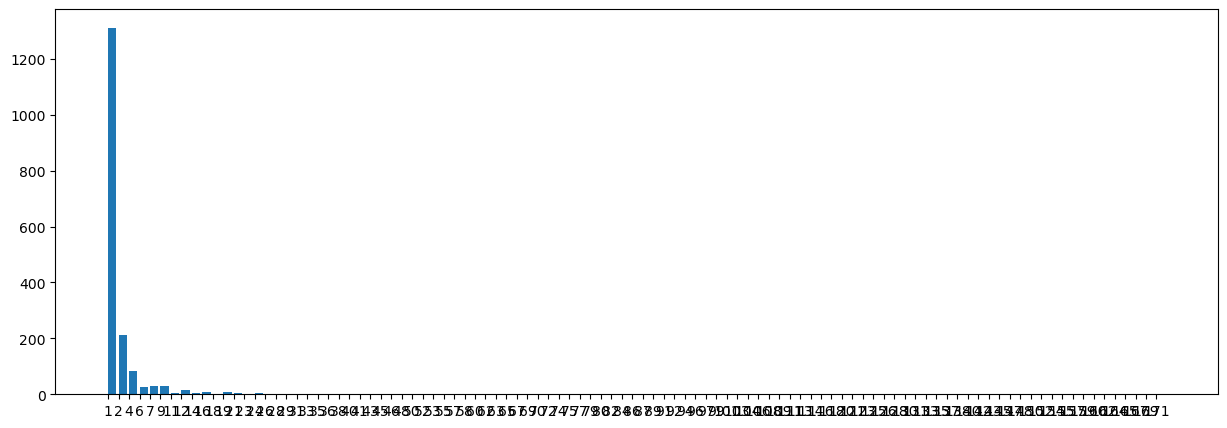

In [10]:
# count the number of occurrences of each city, draw the histogram
_, i = np.unique(users["User_city_zip"], return_counts=True)
cnts, bins = np.histogram(i, bins=100)

_ = plt.subplots(figsize=(15, 5))
plt.bar(
    list(range(len(cnts) + 1)),
    list(cnts) + [0],
    tick_label=[(int(b)) for b in bins],
    align="edge",
)
plt.show()

In [11]:
# first bins
display(bins[1:11])

# the lower bound for the total mass of first ten
sum(np.multiply(bins[:10], cnts[:10])) / len(users)

array([ 2.7,  4.4,  6.1,  7.8,  9.5, 11.2, 12.9, 14.6, 16.3, 18. ])

0.5602980132450331

As we can see, the number of occurrences of each city is quite small, more than 56% of users live in a city that encounter in the dataset up to 18 times. This field is not very informative and we can drop it.

In [12]:
users.drop("User_city_zip", axis=1, inplace=True)

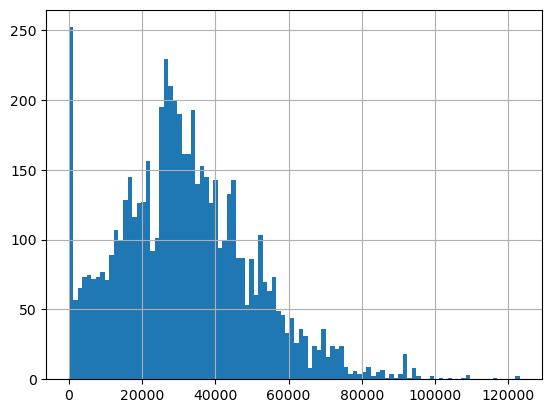

In [13]:
users["User_population_zip"].hist(bins=100)
plt.show()

The population has some variance. We of course can create bins and create populations categories, but we will leave this feature as is.

In [14]:
display(users.head(3))
users.info()

User_Gender  User_Age  User_Occupation User_state_id_zip  \
UserID                                                            
1                F         1               10                MI   
2                M        56               16                LA   
3                M        25               15                MN   

        User_population_zip  
UserID                       
1                   24685.0  
2                   55967.0  
3                   46053.0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6040 entries, 1 to 6040
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   User_Gender          6040 non-null   object 
 1   User_Age             6040 non-null   int64  
 2   User_Occupation      6040 non-null   int64  
 3   User_state_id_zip    6040 non-null   object 
 4   User_population_zip  6040 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 283.1+ KB


## Ratings

In [15]:
ratings.head()

UserID  MovieID  Rating  Timestamp
0       1     1193       5  978300760
1       1      661       3  978302109
2       1      914       3  978301968
3       1     3408       4  978300275
4       1     2355       5  978824291

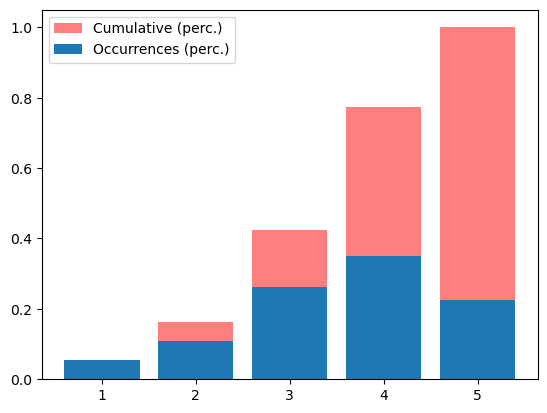

In [16]:
rating, cnts = np.unique(ratings["Rating"], return_counts=True)
cumcnts = np.cumsum(cnts)
cnts, cumcnts = cnts / sum(cnts), cumcnts / sum(cnts)
plt.bar(rating, cumcnts, color="red", alpha=0.5, label="Cumulative (perc.)")
plt.bar(rating, cnts, label="Occurrences (perc.)")
plt.xlabel = "Rating"
plt.ylabel = "% of occurences"
plt.legend()
plt.show()

So, four and five stars receive label 1, one to three (incl.) receive label 0.

In [17]:
ratings["target"] = (ratings["Rating"] >= 4).astype(int)

In [18]:
ratings["Datetime"] = pd.to_datetime(ratings["Timestamp"], utc=True, unit="s")
ratings["Hour"] = ratings["Datetime"].dt.hour
ratings["Month"] = ratings["Datetime"].dt.month
ratings["DoW"] = ratings["Datetime"].dt.weekday
ratings["IsWeekend"] = (ratings["DoW"] >= 5).astype(int)

ratings.drop(["Timestamp", "Rating"], axis=1, inplace=True)

In [19]:
display(ratings.head(3))
ratings.info()

UserID  MovieID  target                  Datetime  Hour  Month  DoW  \
0       1     1193       1 2000-12-31 22:12:40+00:00    22     12    6   
1       1      661       0 2000-12-31 22:35:09+00:00    22     12    6   
2       1      914       0 2000-12-31 22:32:48+00:00    22     12    6   

   IsWeekend  
0          1  
1          1  
2          1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 8 columns):
 #   Column     Non-Null Count    Dtype              
---  ------     --------------    -----              
 0   UserID     1000209 non-null  int64              
 1   MovieID    1000209 non-null  int64              
 2   target     1000209 non-null  int64              
 3   Datetime   1000209 non-null  datetime64[ns, UTC]
 4   Hour       1000209 non-null  int64              
 5   Month      1000209 non-null  int64              
 6   DoW        1000209 non-null  int64              
 7   IsWeekend  1000209 non-null  int64              
dtypes: datetime64[ns, UTC](1), int64(7)
memory usage: 61.0 MB


## Create the final dataset

In [20]:
df = ratings.merge(users, left_on="UserID", right_index=True)
df = df.merge(movies, left_on="MovieID", right_index=True)

In [21]:
df = (
    df.sort_values("Datetime", ascending=True)
    .drop("Datetime", axis=1)
    .reset_index(drop=True)
)

In [22]:
df["IsWeekend"] = df["IsWeekend"].astype("float32")
df["Movie_Year"] = df["Movie_Year"].astype("float32")

In [23]:
display(df.head(3))
df.info()

UserID  MovieID  target  Hour  Month  DoW  IsWeekend User_Gender  User_Age  \
0    6040      858       1    23      4    1        0.0           M        25   
1    6040      593       1    23      4    1        0.0           M        25   
2    6040     2384       1    23      4    1        0.0           M        25   

   User_Occupation  ... Movie_Genre_Fantasy  Movie_Genre_Film-Noir  \
0                6  ...                   0                      0   
1                6  ...                   0                      0   
2                6  ...                   0                      0   

  Movie_Genre_Horror  Movie_Genre_Musical  Movie_Genre_Mystery  \
0                  0                    0                    0   
1                  0                    0                    0   
2                  0                    0                    0   

   Movie_Genre_Romance  Movie_Genre_Sci-Fi  Movie_Genre_Thriller  \
0                    0                   0                     0   
1                    0                   0                     1   
2                    0                   0                     0   

   Movie_Genre_War  Movie_Genre_Western  
0                0                    0  
1                0                    0  
2                0                    0  

[3 rows x 32 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 32 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   UserID                   1000209 non-null  int64  
 1   MovieID                  1000209 non-null  int64  
 2   target                   1000209 non-null  int64  
 3   Hour                     1000209 non-null  int64  
 4   Month                    1000209 non-null  int64  
 5   DoW                      1000209 non-null  int64  
 6   IsWeekend                1000209 non-null  float32
 7   User_Gender              1000209 non-null  object 
 8   User_Age                 1000209 non-null  int64  
 9   User_Occupation          1000209 non-null  int64  
 10  User_state_id_zip        1000209 non-null  object 
 11  User_population_zip      1000209 non-null  float64
 12  Movie_Title              1000209 non-null  object 
 13  Movie_Year               1000209 non-null 

## Features descriptors

In [50]:
desc = {
    "label": "target",
    "deep": {
        # Numerical
        "N": ["User_population_zip", "Movie_Year", "IsWeekend"],
        # Categorical
        "C": {
            # Int
            "I": [
                {
                    "name": "MovieID",
                    "embed": False,
                    "drop": True,
                },
                {
                    "name": "UserID",
                    "embed": False,
                    "drop": True,
                },
                {
                    "name": "Hour",
                    "embed": True,
                },
                {
                    "name": "Month",
                    "embed": True,
                },
                {
                    "name": "DoW",
                    "embed": True,
                },
                {
                    "name": "User_Age",
                    "embed": True,
                },
                {
                    "name": "User_Occupation",
                    "embed": True,
                },
            ],
            # String
            "S": [
                {
                    "name": "User_Gender",
                    "embed": True,
                },
                {
                    "name": "User_state_id_zip",
                    "embed": True,
                },
            ],
        },
        # Embedding
        "E": ["Movie_Title"],
        # Multi-Hot
        "MH": [
            {
                "name": "Movie_Genre",
                "columns": [
                    name for name in df.columns if name.startswith("Movie_Genre_")
                ],
                "embed": True,
            },
        ],
    },
    "wide": {
        # Binary
        "B": ["IsWeekend", "Movie_Genre"],
        # One-hot
        "C": {
            # Int
            "I": [
                {
                    "name": "MovieID",
                },
                {
                    "name": "UserID",
                },
                {
                    "name": "Hour",
                },
                {
                    "name": "Month",
                },
                {
                    "name": "DoW",
                },
                {
                    "name": "User_Age",
                },
                {
                    "name": "User_Occupation",
                },
            ],
            # String
            "S": [
                {
                    "name": "User_Gender",
                },
                {
                    "name": "User_state_id_zip",
                },
            ],
        },
        # Cross
        "X": [
            ["UserID", "Movie_Genre"],
            ["User_Age", "User_Gender"],
            ["DoW", "Hour"],
        ],
    },
}

In [51]:
with FEATURE_DESC.open("w") as f:
    json.dump(desc, f)

## Categorical features vocabulary

In [26]:
vocab = {}
for f in sum(desc["deep"]["C"].values(), []):
    name = f["name"]
    vocab[name] = df[name].unique().tolist()

with DATA_VOCAB.open("w") as f:
    json.dump(vocab, f)

## Split

In [27]:
df_train, df_val = train_test_split(df, test_size=0.2, shuffle=False)
df_val, df_test = train_test_split(df_val, test_size=0.5, shuffle=False)

In [28]:
df_train.to_csv(DATA_TRAIN, index=False)
df_val.to_csv(DATA_VAL, index=False)
df_test.to_csv(DATA_TEST, index=False)